In [1]:
# Libraries
import os
import glob
import subprocess
import multiprocessing as mp

# Clean warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime


# Models
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier

# Animation
# plt.rcParams['animation.ffmpeg_path'] = '/home/donofiva/anaconda3/bin/ffmpeg'
from matplotlib import animation, rc
rc('animation', html='jshtml')

Importing plotly failed. Interactive plots will not work.


# Data exploration

## Load dataset

### Timeseries

In [2]:
timeseries = pd.read_csv('data/timeseries.csv')
timeseries.columns = [column.upper() for column in timeseries.columns]
timeseries = timeseries.sort_values(['TURBID', 'DAY', 'TMSTAMP'])

In [3]:
timeseries

,TURBID,DAY,TMSTAMP,WSPD,WDIR,ETMP,ITMP,NDIR,PAB1,PAB2,PAB3,PRTV,PATV
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,23:10,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,-111.69,601.44
4727516,134,245,23:20,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,-72.67,673.79
4727517,134,245,23:30,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,-118.70,999.36
4727518,134,245,23:40,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,-58.12,1100.89


### Location

In [4]:
location = pd.read_csv('data/location.csv')
location.columns = [column.upper() for column in location.columns]
location = location.sort_values(['TURBID'])

## Visualization

### Windmill location

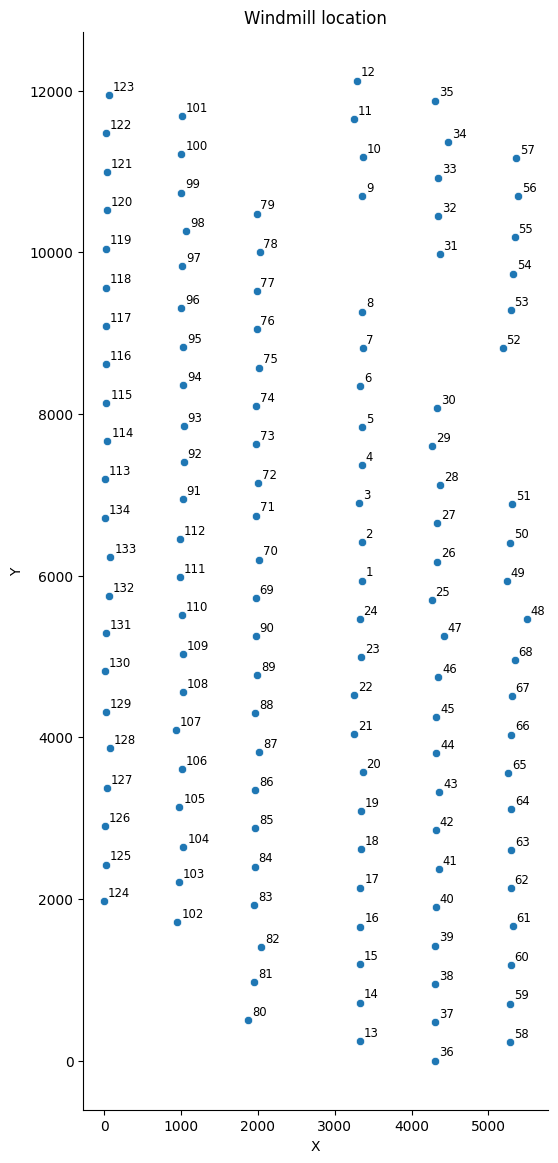

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 14))
sns.scatterplot(x=location['X'], y=location['Y'], ax=ax)

for index, row in location.iterrows():
    plt.text(
        row['X'] + 50, 
        row['Y'] + 60, 
        int(row['TURBID']),
        fontsize='small'
    )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Windmill location')
plt.show()

### Timeseries

In [6]:
turbine = timeseries[timeseries['TURBID'] == 1]
missing_values = turbine[turbine['PATV'].isnull()].index
turbine = turbine.fillna(0)

In [7]:
# Stored filled timeseries dataframe to draw heatmaps
timeseries_filled = timeseries.copy().fillna(0)

# Remove outliers to enforce visualization coherence
timeseries_filled['PATV'] = timeseries_filled['PATV'].map(lambda patv: max(0, patv))
timeseries_filled['ETMP'] = timeseries_filled['ETMP'].map(lambda etmp: max(min(etmp, 45.0), -5.0))
timeseries_filled['ITMP'] = timeseries_filled['ITMP'].map(lambda itmp: max(min(itmp, 45.0), -5.0))

In [8]:
timeseries_filled

,TURBID,DAY,TMSTAMP,WSPD,WDIR,ETMP,ITMP,NDIR,PAB1,PAB2,PAB3,PRTV,PATV
0,1,1,00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,23:10,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,-111.69,601.44
4727516,134,245,23:20,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,-72.67,673.79
4727517,134,245,23:30,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,-118.70,999.36
4727518,134,245,23:40,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,-58.12,1100.89


#### Correlation

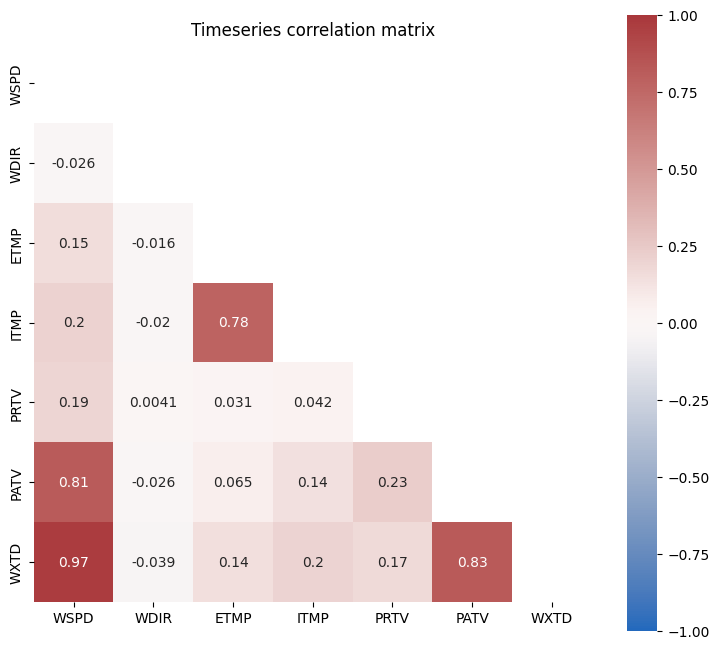

In [9]:
# Initialize correlation matrix plot
fig, ax = plt.subplots(figsize=(9, 8))

# Additional wind feature
timeseries_filled_correlation = timeseries_filled.copy()
timeseries_filled_correlation['WXTD'] = timeseries_filled_correlation['WSPD'] * np.cos(np.radians(timeseries_filled['WDIR']))

# Mask uninformative values
correlation_matrix = timeseries_filled_correlation[['WSPD', 'WDIR', 'ETMP', 'ITMP', 'PRTV', 'PATV', 'WXTD']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot correlation matrix
sns.heatmap(correlation_matrix, mask=mask, vmin=-1, vmax=1, cmap='vlag', annot=True, ax=ax, square=True)
plt.title('Timeseries correlation matrix')
plt.show()

#### Timeseries autocorrelation

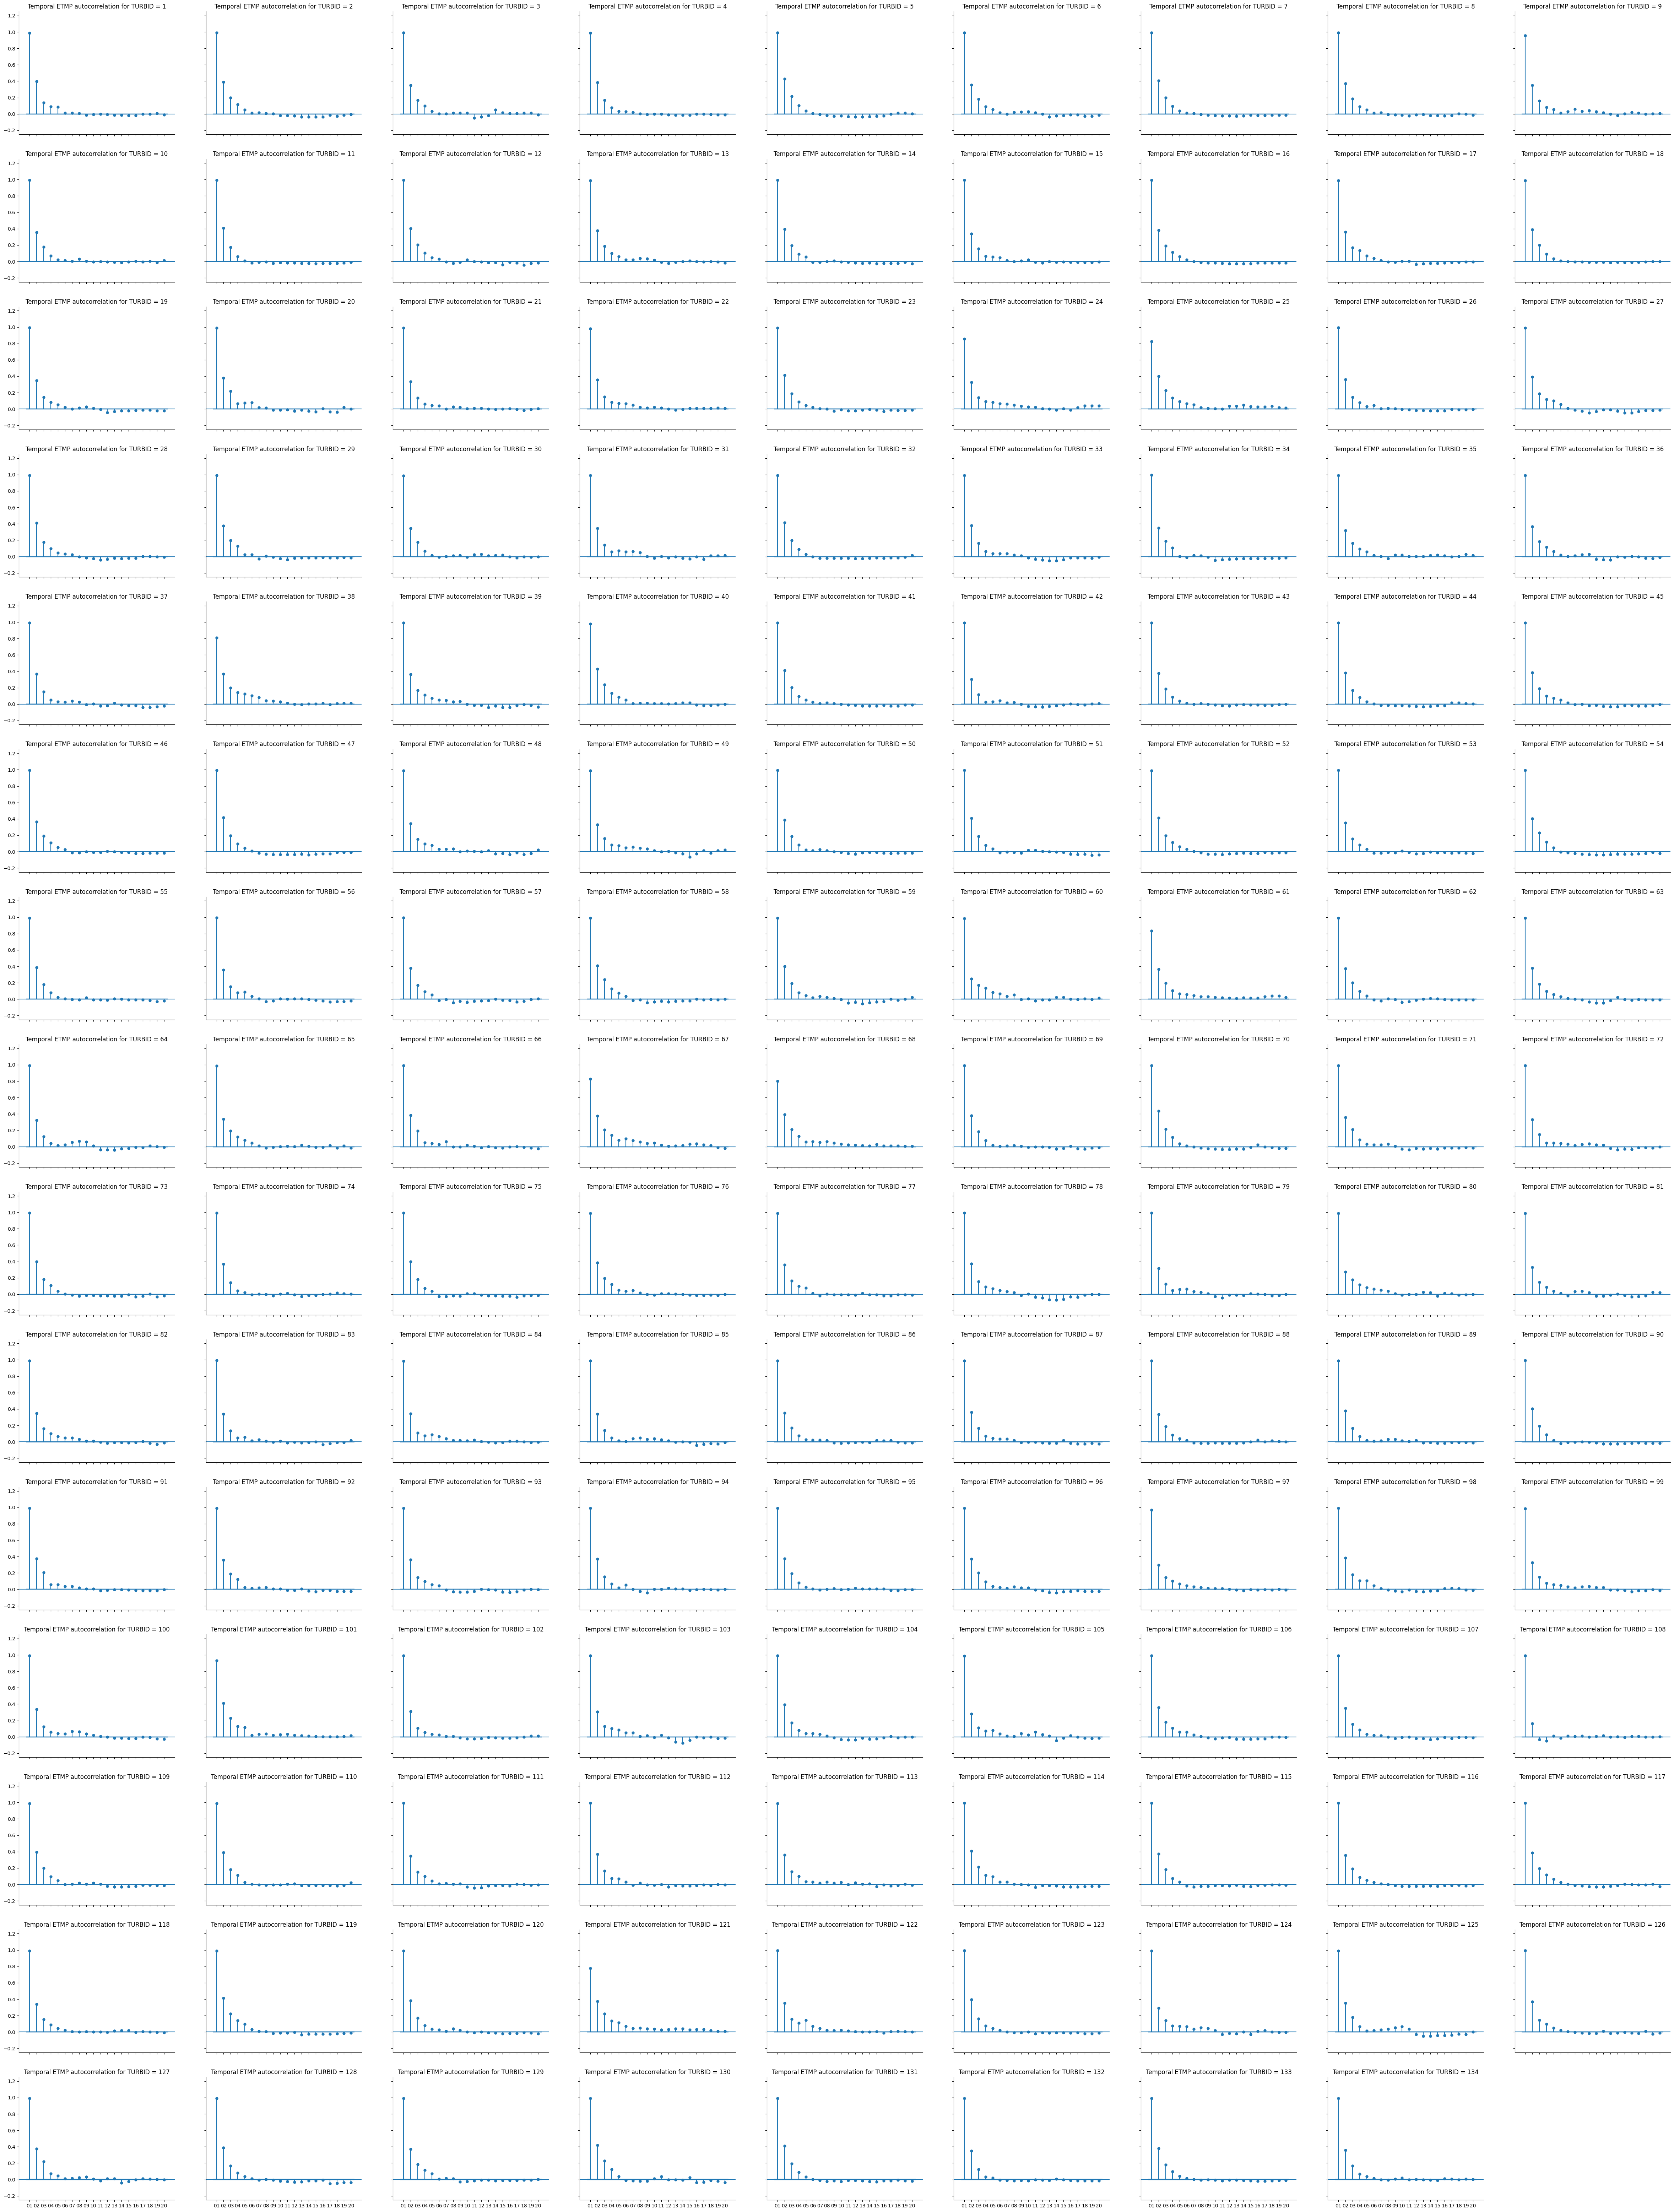

In [10]:
fig, axs = plt.subplots(15, 9, figsize=(60, 80), sharex=True, sharey=True)
for turbine_id, ax in zip(sorted(timeseries_filled['TURBID'].unique()), axs.flatten()):
    
    # Plot autocorrelation
    plot_pacf(timeseries_filled[timeseries_filled['TURBID'] == turbine_id]['ETMP'], lags=20, title=f'Temporal ETMP autocorrelation for TURBID = {turbine_id}', ax=ax, zero=False)
    
    # Remove useless axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim([-.25, 1.25])
    ax.set_xticks(list(range(1, 21)))
    ax.set_xticklabels([str(label).zfill(2) for label in range(1, 21)])
    
# Remove last unused plot
fig.delaxes(axs[-1][-1])
plt.show()

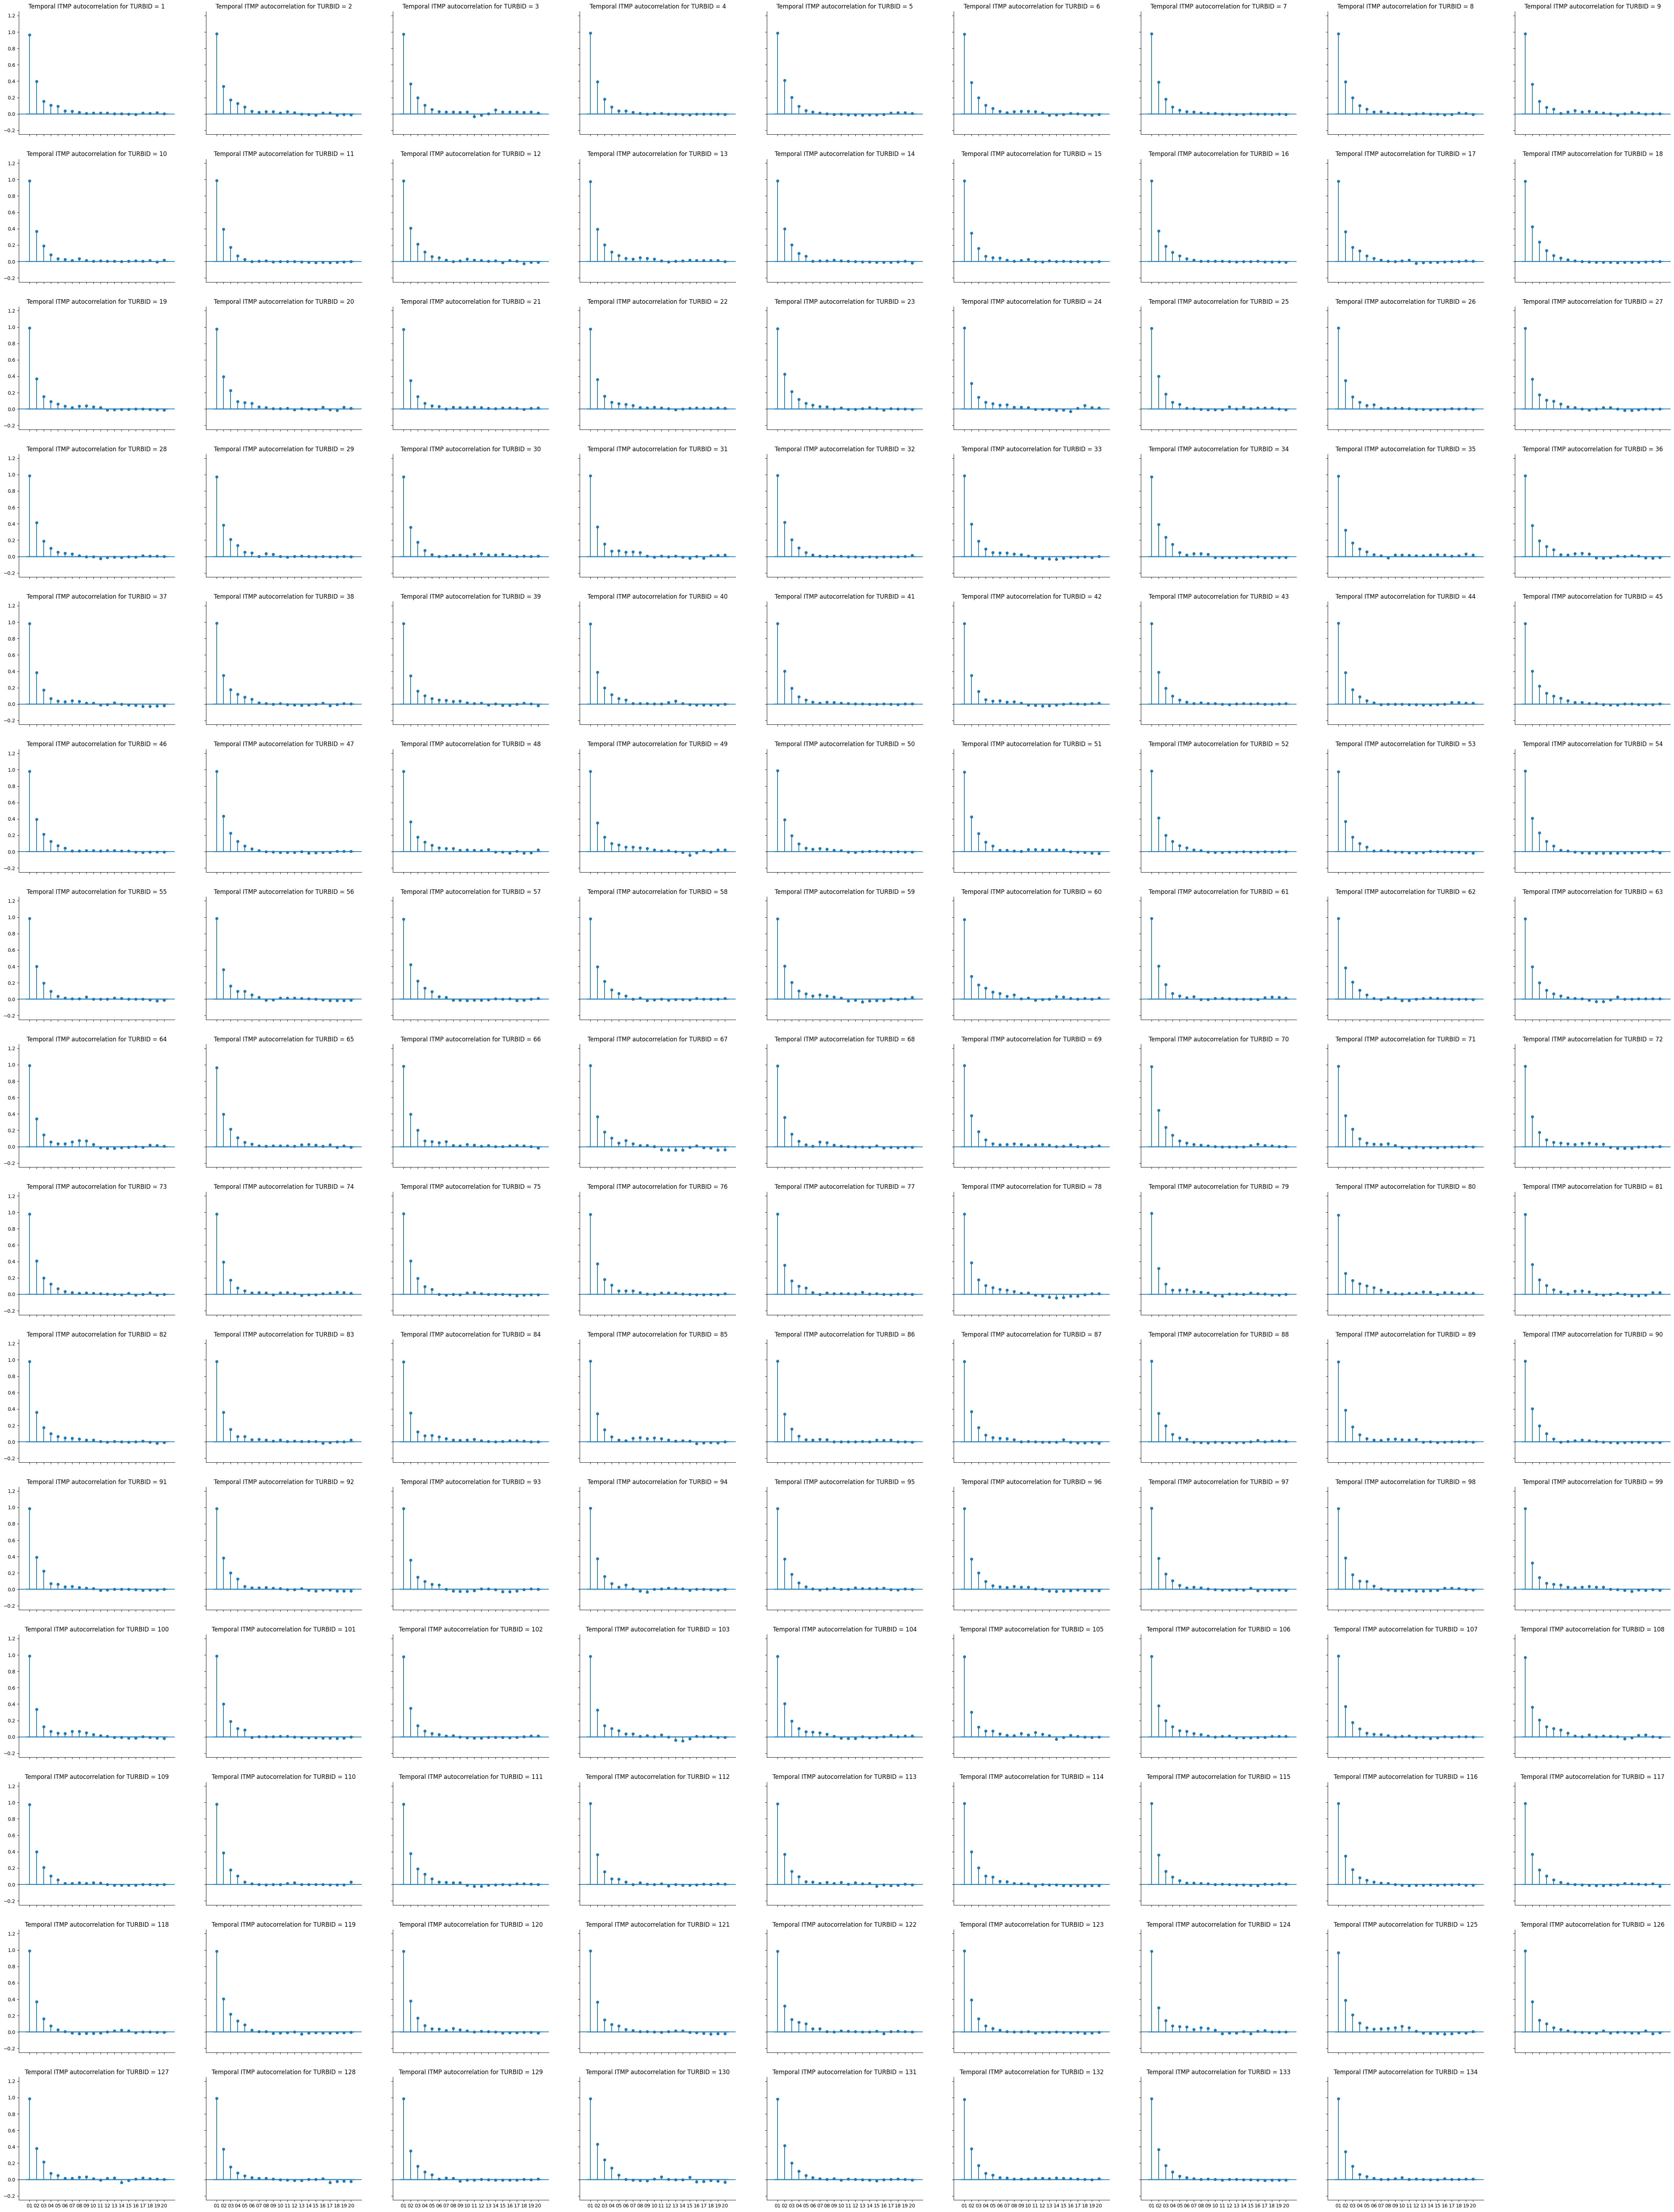

In [11]:
fig, axs = plt.subplots(15, 9, figsize=(60, 80), sharex=True, sharey=True)
for turbine_id, ax in zip(sorted(timeseries_filled['TURBID'].unique()), axs.flatten()):
    
    # Plot autocorrelation
    plot_pacf(timeseries_filled[timeseries_filled['TURBID'] == turbine_id]['ITMP'], lags=20, title=f'Temporal ITMP autocorrelation for TURBID = {turbine_id}', ax=ax, zero=False)
    
    # Remove useless axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim([-.25, 1.25])
    ax.set_xticks(list(range(1, 21)))
    ax.set_xticklabels([str(label).zfill(2) for label in range(1, 21)])
    
# Remove last unused plot
fig.delaxes(axs[-1][-1])
plt.show()

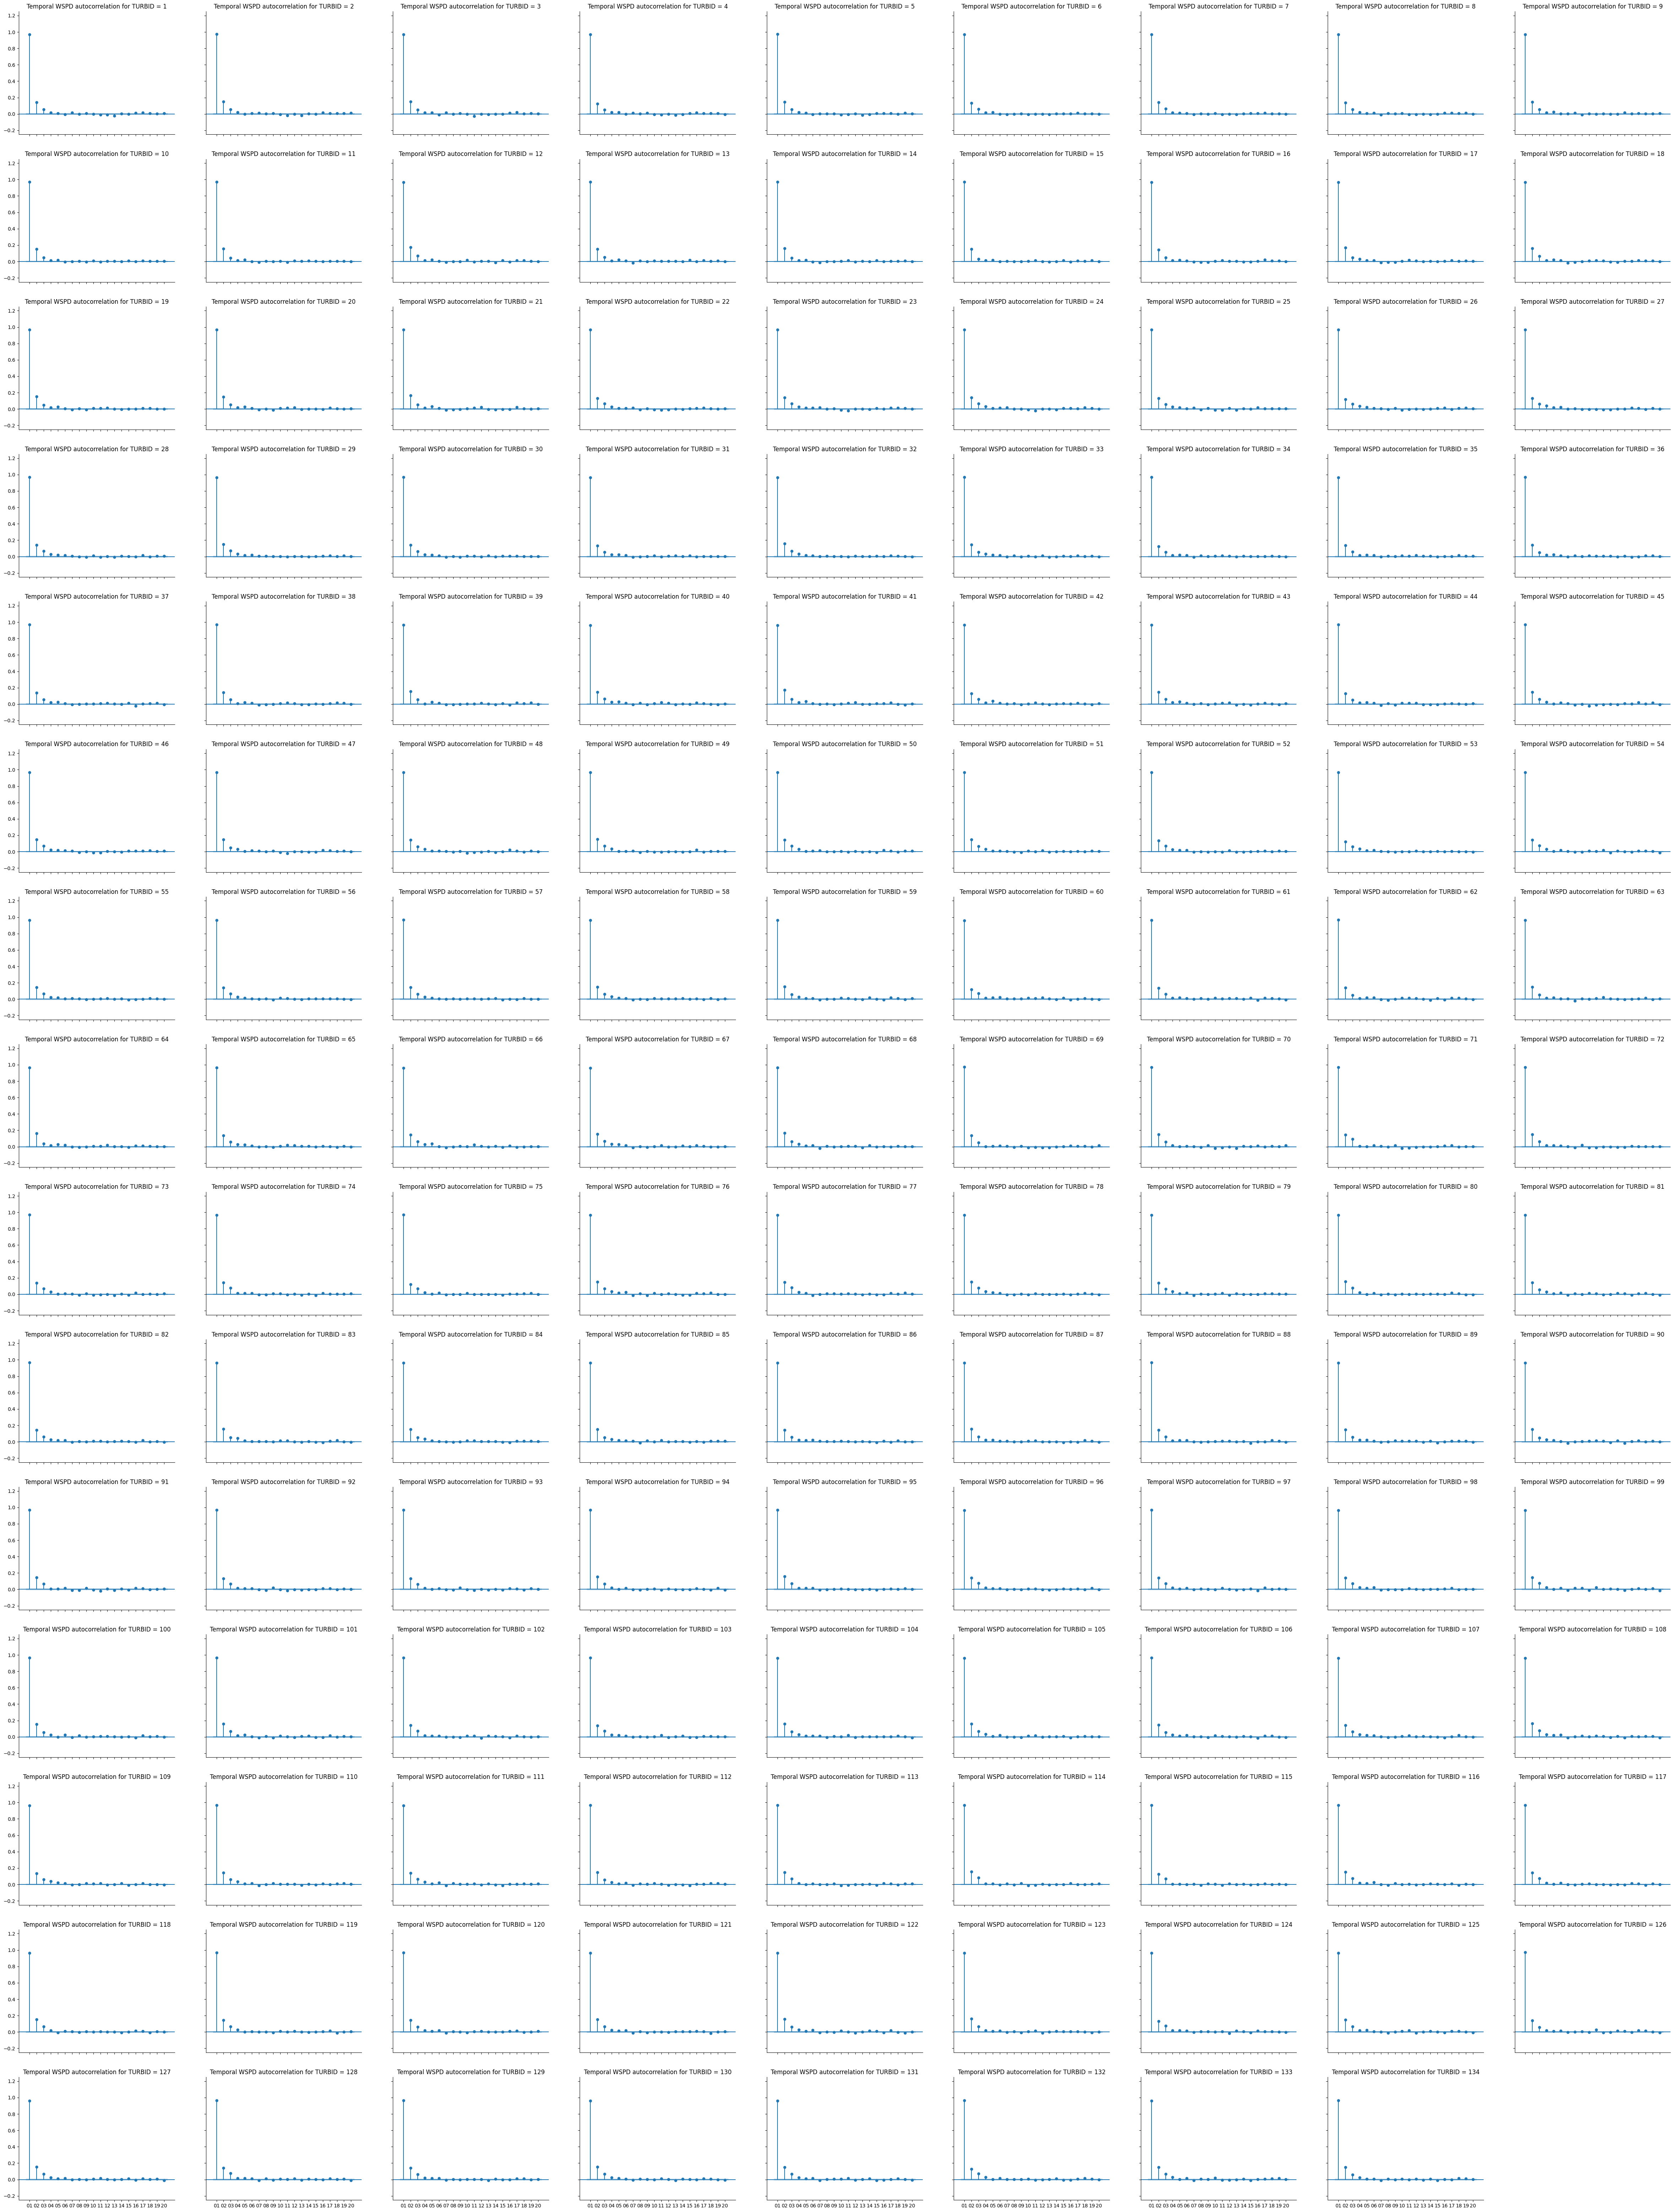

In [12]:
fig, axs = plt.subplots(15, 9, figsize=(60, 80), sharex=True, sharey=True)
for turbine_id, ax in zip(sorted(timeseries_filled['TURBID'].unique()), axs.flatten()):
    
    # Plot autocorrelation
    plot_pacf(timeseries_filled[timeseries_filled['TURBID'] == turbine_id]['WSPD'], lags=20, title=f'Temporal WSPD autocorrelation for TURBID = {turbine_id}', ax=ax, zero=False)
    
    # Remove useless axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim([-.25, 1.25])
    ax.set_xticks(list(range(1, 21)))
    ax.set_xticklabels([str(label).zfill(2) for label in range(1, 21)])
    
# Remove last unused plot
fig.delaxes(axs[-1][-1])
plt.show()

In [13]:
index = timeseries.groupby('TMSTAMP').agg({'ETMP': sum}).index
index

Index(['00:00', '00:10', '00:20', '00:30', '00:40', '00:50', '01:00', '01:10',
       '01:20', '01:30',
       ...
       '22:20', '22:30', '22:40', '22:50', '23:00', '23:10', '23:20', '23:30',
       '23:40', '23:50'],
      dtype='object', name='TMSTAMP', length=144)

#### Correlation between series

In [14]:
timeseries[['DAY', 'TMSTAMP', 'TURBID', 'ETMP']].pivot_table(index=['DAY', 'TMSTAMP'], columns='TURBID', values='ETMP', dropna=False)

TURBID         1      2      3      4      5      6      7      8      9    \
DAY TMSTAMP                                                                  
1   00:00      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
    00:10    30.73  25.45  31.38  32.72  30.11  30.90  32.21  31.59  37.96   
    00:20    30.60  25.34  31.29  32.62  30.08  30.90  32.20  31.59  37.95   
    00:30    30.52  25.29  31.29  32.51  30.00  30.90  32.20  31.59  37.86   
    00:40    30.49  25.29  31.26  32.49  30.00  30.85  32.16  31.57  37.80   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
245 23:10     1.13  -5.55  -1.53   6.42  -2.53  -1.20  -0.26   0.51  24.16   
    23:20     2.09  -5.72  -1.66   6.26  -2.69  -1.37  -0.35   0.31  23.98   
    23:30     2.29  -5.89  -1.76   6.10  -2.84  -1.47  -0.43   0.06  23.90   
    23:40     2.14  -6.05  -1.91   5.99  -2.95  -1.59  -0.58  -0.07  23.86   
    23:50     2.04  -6.17  -2.00   5.90  -3.01  -1.58  -0.66  -0.27  23.77   

TURBID         10   ...    125    126    127    128    129    130    131  \
DAY TMSTAMP         ...                                                    
1   00:00      NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
    00:10    31.57  ...  29.95  34.11  35.58  30.76  30.29  31.39  32.38   
    00:20    31.48  ...  29.93  34.01  35.45  30.70  30.21  31.27  31.66   
    00:30    31.40  ...  29.71  33.91  36.49  30.59  30.07  31.15  31.45   
    00:40    31.40  ...  29.63  33.72  35.41  30.45  29.96  31.02  31.46   
...            ...  ...    ...    ...    ...    ...    ...    ...    ...   
245 23:10    -1.54  ...  -1.57  -0.51  -1.43  -1.39  -0.20  -0.50  -0.88   
    23:20    -1.76  ...  -1.50  -0.76  -1.30  -1.39  -0.20  -0.50  -0.68   
    23:30    -1.76  ...  -1.50  -0.65  -1.24  -1.30  -0.19  -0.50  -0.66   
    23:40    -1.80  ...  -1.64  -0.47  -1.29  -1.30   0.00  -0.50  -0.70   
    23:50    -1.85  ...  -1.70  -0.39  -1.01  -1.24   0.21  -0.49  -0.60   

TURBID         132    133    134  
DAY TMSTAMP                       
1   00:00      NaN    NaN    NaN  
    00:10    29.98  32.74  30.83  
    00:20    29.90  32.65  30.79  
    00:30    29.78  32.53  30.77  
    00:40    29.63  32.40  30.72  
...            ...    ...    ...  
245 23:10    -1.93   1.30  -0.07  
    23:20    -2.10   1.21   0.23  
    23:30    -2.05   1.28  -0.16  
    23:40    -2.10   1.41  -0.14  
    23:50    -2.10   1.50  -0.06  

[35280 rows x 134 columns]

<Axes: xlabel='TURBID', ylabel='TURBID'>

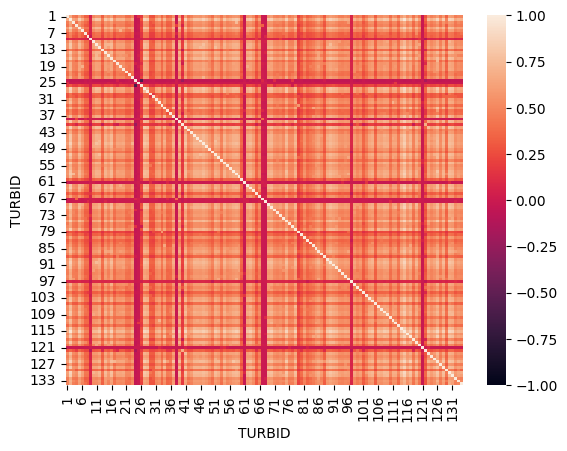

In [15]:
sns.heatmap(timeseries[['DAY', 'TMSTAMP', 'TURBID', 'ETMP']].pivot_table(index=['DAY', 'TMSTAMP'], columns='TURBID', values='ETMP', dropna=False).corr(), vmax=1, vmin=-1)

#### Energy production (one turbine)

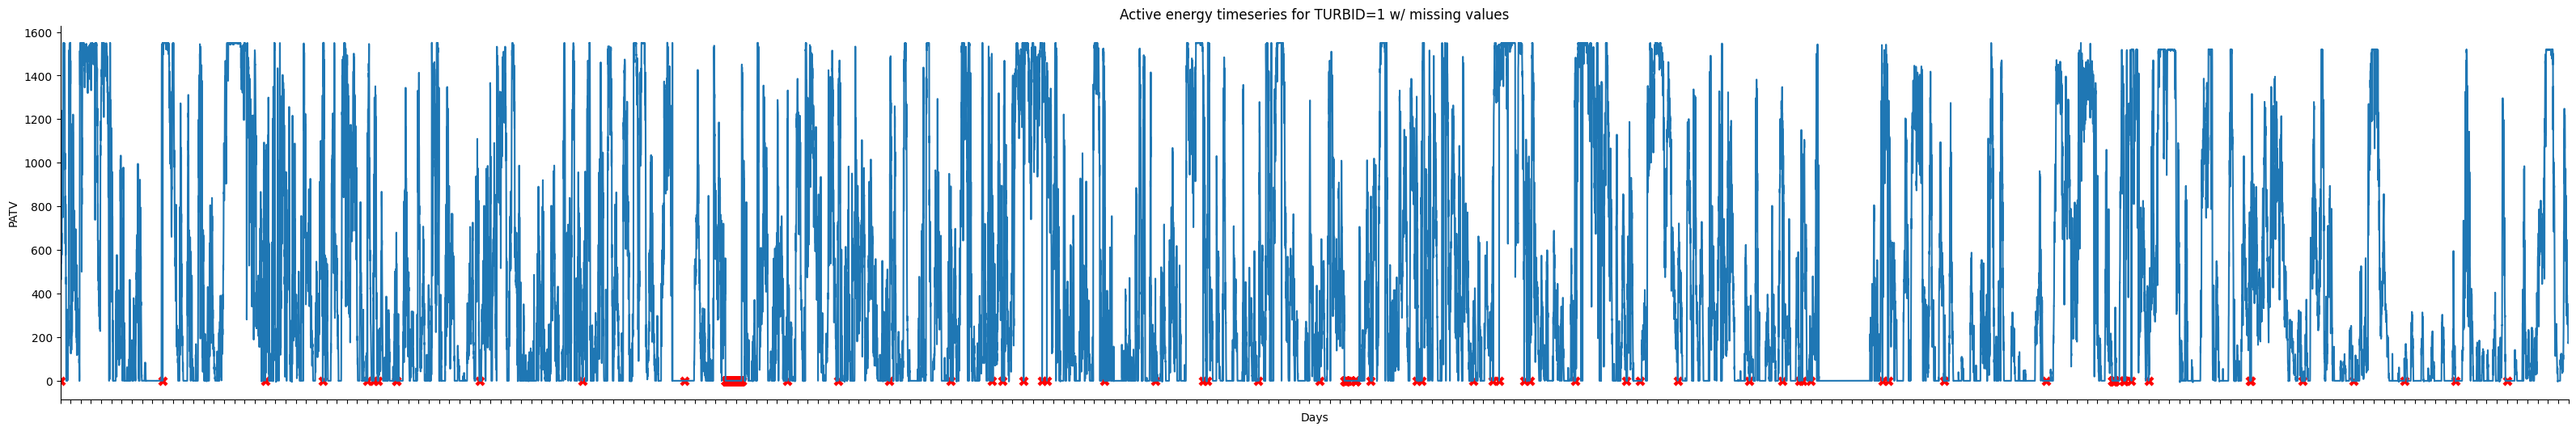

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(40, 6))
sns.lineplot(x=turbine.index, y=turbine['PATV'], ax=ax)
ax.scatter(missing_values, [0] * len(missing_values), c='red', marker='X', s=75, linewidth=.01)

# Set daily locator
ax.xaxis.set_major_locator(plt.MultipleLocator(6 * 24))
ax.xaxis.set_ticklabels([])

# Customize x axis
ax.set_xlabel('Days')
ax.set_xlim([0, len(turbine)])

# Customize plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Active energy timeseries for TURBID=1 w/ missing values')
plt.show()

#### Seasonality: energy

In [17]:
turbine_total = timeseries_filled.groupby(['DAY', 'TMSTAMP'], as_index=False).agg(PATV=('PATV', 'mean'), WSPD=('WSPD', 'mean'))

In [18]:
# Building prophet DataFrame
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cumulative_days_in_month = np.cumsum(days_in_month)

In [19]:
def assign_day_to_month(day):
    return np.argmax(cumulative_days_in_month >= day) + 1

def convert_indices_to_datetime(row):
    return datetime(
        year=row['YEAR'],
        month=row['MONTH'],
        day=(row['DAY'] - int(np.sum(days_in_month[:row['MONTH'] - 1]))),
        hour=int(row['TMSTAMP'].split(':')[0]),
        minute=int(row['TMSTAMP'].split(':')[1])  
    )

prophet_turbine = turbine_total.copy()
prophet_turbine['MONTH'] = prophet_turbine['DAY'].apply(assign_day_to_month)
prophet_turbine['YEAR'] = 2021
prophet_turbine['DATE'] = prophet_turbine.apply(convert_indices_to_datetime, axis=1)
prophet_turbine = prophet_turbine[['DATE', 'PATV']]

In [20]:
# Define Prophet columns
prophet_turbine.columns = ['ds', 'y']

# Initialize Prophet and fit dataset
prophet = Prophet(yearly_seasonality=False)
_ = prophet.fit(prophet_turbine)

22:41:01 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing


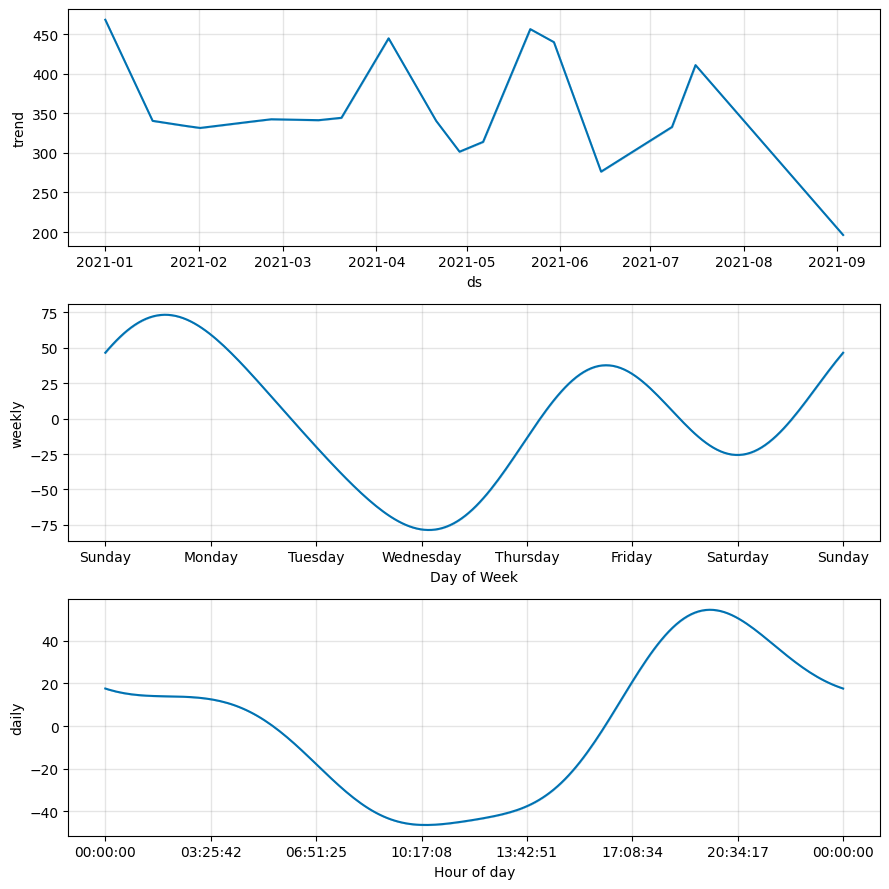

In [21]:
# Predict empty future to get seasonality
empty_future = prophet.make_future_dataframe(periods=0)
empty_forecast = prophet.predict(empty_future)
_ = prophet.plot_components(empty_forecast)

#### Seasonality: wind

In [22]:
def assign_day_to_month(day):
    return np.argmax(cumulative_days_in_month >= day) + 1

def convert_indices_to_datetime(row):
    return datetime(
        year=row['YEAR'],
        month=row['MONTH'],
        day=(row['DAY'] - int(np.sum(days_in_month[:row['MONTH'] - 1]))),
        hour=int(row['TMSTAMP'].split(':')[0]),
        minute=int(row['TMSTAMP'].split(':')[1])  
    )

prophet_turbine = turbine_total.copy()
prophet_turbine['MONTH'] = prophet_turbine['DAY'].apply(assign_day_to_month)
prophet_turbine['YEAR'] = 2021
prophet_turbine['DATE'] = prophet_turbine.apply(convert_indices_to_datetime, axis=1)
prophet_turbine = prophet_turbine[['DATE', 'WSPD']]

In [23]:
# Define Prophet columns
prophet_turbine.columns = ['ds', 'y']

# Initialize Prophet and fit dataset
prophet = Prophet(yearly_seasonality=False)
_ = prophet.fit(prophet_turbine)

22:41:10 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing


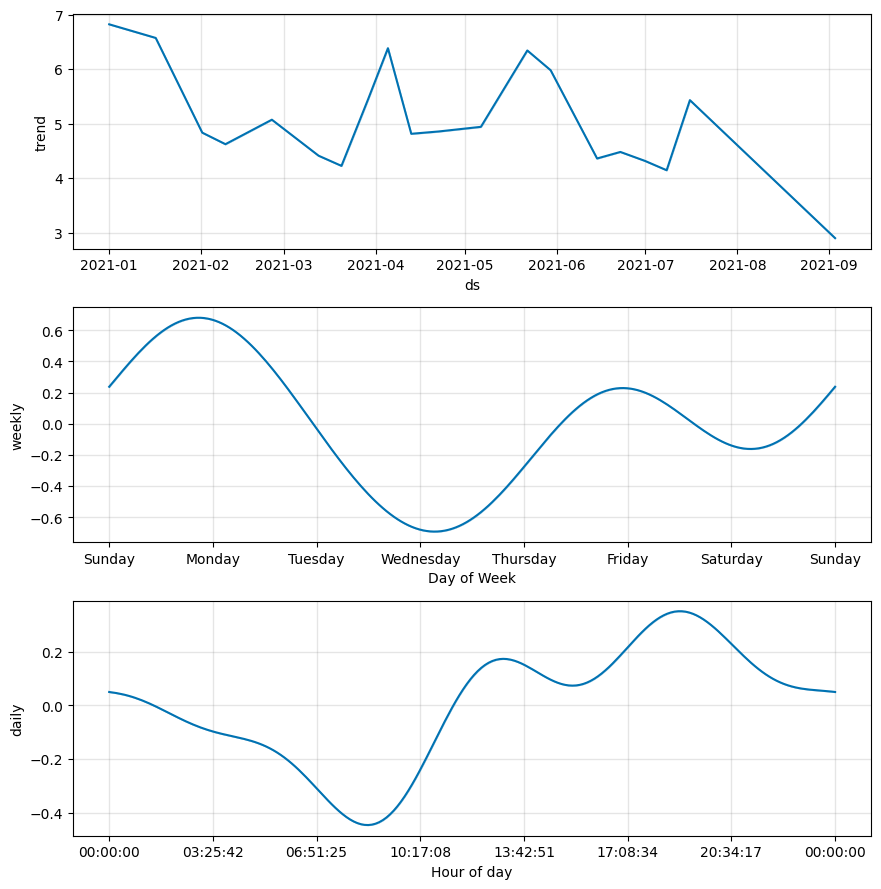

In [24]:
# Predict empty future to get seasonality
empty_future = prophet.make_future_dataframe(periods=0)
empty_forecast = prophet.predict(empty_future)
_ = prophet.plot_components(empty_forecast)

#### Temperature, wind & active energy maps

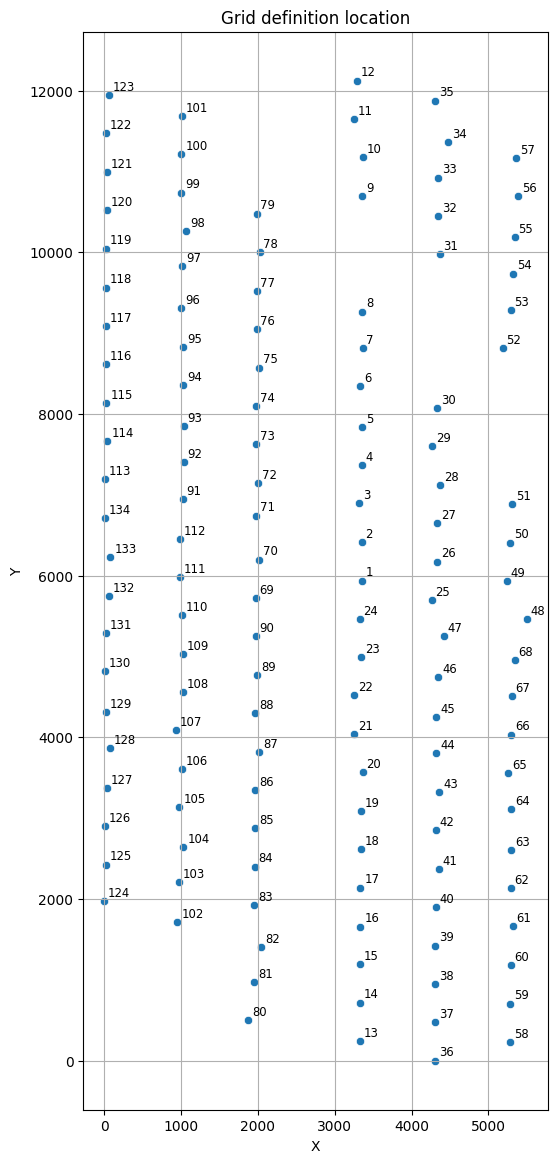

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 14))
sns.scatterplot(x=location['X'], y=location['Y'], ax=ax)

for index, row in location.iterrows():
    plt.text(
        row['X'] + 50, 
        row['Y'] + 60, 
        int(row['TURBID']),
        fontsize='small'
    )


# Set ticks for grid visualization
# ax.xaxis.set_ticks(list())
# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticks(list(range()))
# ax.yaxis.set_ticklabels([])

plt.grid()
plt.title('Grid definition location')
plt.show()

In [28]:
# Define grid to index assignment to draw heatmap 
grid_assignment = {
    (upper_bound, left_bound, lower_bound, right_bound): (y, x)
    for y, (lower_bound, upper_bound) in enumerate(zip(reversed(np.arange(0, 12400, 400)), reversed(np.arange(400, 12800, 400))))
    for x, (left_bound, right_bound) in enumerate(zip(np.arange(0, 5600, 400), np.arange(400, 6000, 400)))
}

# Define turbine to index assignment to draw heatmap 
turbine_assignment = {
    int(row['TURBID']): [
        grid_assignment[upper_bound, left_bound, lower_bound, right_bound]
        for upper_bound, left_bound, lower_bound, right_bound in grid_assignment.keys()
        if upper_bound >= row['Y'] and lower_bound <= row['Y'] and right_bound >= row['X'] and left_bound <= row['X']
    ].pop()
    for _, row in location.iterrows()
}

turbine_assignment_reversed = {
    value: key
    for key, value in turbine_assignment.items()
}

In [29]:
# Define heatmap labels
heatmap_labels = np.zeros((31, 14)).astype(str)

for y, row in enumerate(heatmap_labels):
    for x, col in enumerate(row):
        heatmap_labels[y, x] = str(turbine_assignment_reversed.get((y, x), ''))

In [30]:
def build_heatmap(values):
    
    # Define empty heatmap
    heatmap = np.zeros((31, 14))
    
    # Store heatmap values
    for turbine_id, value in zip(timeseries_filled.loc[values.index, 'TURBID'], values):
        heatmap[turbine_assignment[int(turbine_id)]] = value
        
    return heatmap,

In [31]:
def build_wind_quiver(values):
    return list(
        zip(
            timeseries_filled.loc[values.index, 'NDIR'],
            timeseries_filled.loc[values.index, 'WSPD'],
            timeseries_filled.loc[values.index, 'WDIR']
        )
    )

In [32]:
# Extract heatmap representation from data using grid assignment
heatmaps = timeseries_filled.groupby(['DAY', 'TMSTAMP'], as_index=False).agg(
    EXTERNAL_TEMPERATURE_HEATMAP=('ETMP', build_heatmap),
    INTERNAL_TEMPERATURE_HEATMAP=('ITMP', build_heatmap),
    ACTIVE_ENERGY_PRODUCTION=('PATV', build_heatmap),
    NACELLE_WIND_DIRECTION_SPEED=('WSPD', build_wind_quiver)
)

# I don't know why, but we now have to unpack heatmaps
for column in ['EXTERNAL_TEMPERATURE_HEATMAP', 'INTERNAL_TEMPERATURE_HEATMAP', 'ACTIVE_ENERGY_PRODUCTION']:
    heatmaps[column] = heatmaps[column].map(lambda heatmap: heatmap[0])

In [33]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [34]:
vlag = sns.color_palette('vlag', as_cmap=True)
temperature_cmap = shiftedColorMap(vlag, start=0, midpoint=.1, stop=1, name='vlag_custom')
energy_cmap = sns.color_palette('rocket', as_cmap=True)

/var/folders/qv/mvb8szpn0zgfn8vn02k7c24m0000gn/T/ipykernel_83025/836158580.py:48: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)


In [35]:
# Define animation function
def plot_heatmap(heatmap_column: str, i: int, limits, colorbar, log=False):

    # Store limits
    vmin, vmax = limits
    
    # Plot heatmap grid
    fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(6, 14), gridspec_kw={'width_ratios': (.9, .05)}, dpi=200)
    ax.tick_params(left=False, bottom=False)
    ax.set_title(f"{heatmap_column.replace('_HEATMAP', '').replace('_', ' ').lower().capitalize()}: day %d, hour %s" % (heatmaps.loc[i, 'DAY'], heatmaps.loc[i, 'TMSTAMP']))
    sns.heatmap(ax=ax, data=heatmaps[heatmap_column].tolist()[i], cmap=colorbar, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax, annot=heatmap_labels, fmt='', yticklabels=False, xticklabels=False)
    plt.savefig(f"video/{heatmap_column.lower()}/frame%s.png" % str(i).zfill(5))
    plt.close()
    
    if log:
        print(f'Frame {i}')
    
def plot_quiver(i: int):
    
    # Store wind data
    nacelle_direction, wind_speed, wind_direction = zip(*heatmaps['NACELLE_WIND_DIRECTION_SPEED'][i])
    
    # Generate figure
    fig, ax = plt.subplots(figsize=(6, 14), dpi=200)

    # Define windmills position
    ax.scatter(
        location['X'], 
        location['Y'],
        color='black',
        s=15
    )

    # Plot wind data
    ax.quiver(
        location['X'], 
        location['Y'], 
        np.cos(np.radians(nacelle_direction)), 
        np.sin(np.radians(nacelle_direction)),
        width=.005
    )

    ax.quiver(
        location['X'], 
        location['Y'], 
        np.array(wind_speed) * np.cos(np.radians(wind_direction)) * np.cos(np.radians(nacelle_direction)), 
        np.array(wind_speed) * np.sin(np.radians(wind_direction)) * np.sin(np.radians(nacelle_direction)),
        color='red',
        width=.005
    )

    # Handle plot
    ax.set_xlim((-500, 6000))
    ax.set_ylim((-500, 13000))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f"Wind: day %d, hour %s" % (heatmaps.loc[i, 'DAY'], heatmaps.loc[i, 'TMSTAMP']))
    plt.savefig(f"video/{'NACELLE_WIND_DIRECTION_SPEED'.lower()}/frame%s.png" % str(i).zfill(5))
    plt.close()
    
def store_frames(heatmap_column, limits, colorbar, log=False):

    # Open home directory
    # os.chdir('/home/donofiva/projects/thesis')
    os.makedirs(f'video/{heatmap_column.lower()}', exist_ok=True)
    
    # Multiprocessing 
    if heatmap_column != 'NACELLE_WIND_DIRECTION_SPEED':
        
        def target(queue, heatmap_column):
            while not queue.empty():
                plot_heatmap(heatmap_column, queue.get(), limits, colorbar)
                queue.task_done()
                
    else:
        
        def target(queue, heatmap_column):
            while not queue.empty():
                plot_quiver(queue.get())
                queue.task_done()

    # Define queue
    queue = mp.JoinableQueue()

    # Add indices
    for index in range(len(heatmaps)):
        queue.put(index)

    # Define processes
    processes = [mp.Process(target=target, args=(queue, heatmap_column)) for _ in range(8)]

    # Start processes
    for process in processes:
        process.start()

    # Join queue
    queue.join()

    # Join processes
    for process in processes:
        process.join()
        
def generate_animation(heatmap_column, remove_files=False):
    
    # Generate video
    os.chdir(f"video/{heatmap_column.lower()}")
    subprocess.call([
        'ffmpeg', '-framerate', '100', '-i', 'frame%5d.png', '-filter:v', 'fps=100', '-pix_fmt', 'yuv420p',
        f'../{heatmap_column.lower()}.mp4'
    ])
    
    # Remove files if needed
    if remove_files:
        for file_name in glob.glob("*.png"):
            os.remove(file_name)
    
    # Go back to proper directory   
    os.chdir('/home/donofiva/projects/thesis')
    return

In [ ]:
# Create animation
store_frames('EXTERNAL_TEMPERATURE_HEATMAP', (-5, 45), temperature_cmap)
# store_frames('INTERNAL_TEMPERATURE_HEATMAP', (-5, 45), temperature_cmap)
# store_frames('ACTIVE_ENERGY_PRODUCTION', (0, 1600), energy_cmap)
# store_frames('NACELLE_WIND_DIRECTION_SPEED', None, None)

In [ ]:
# generate_animation('EXTERNAL_TEMPERATURE_HEATMAP')
# generate_animation('INTERNAL_TEMPERATURE_HEATMAP')
# generate_animation('ACTIVE_ENERGY_PRODUCTION')
# generate_animation('NACELLE_WIND_DIRECTION_SPEED')

In [ ]:
# !jupyter nbconvert --to script "Data exploration.ipynb"

#### Wind sensors shape

In [ ]:
# Define shape dataset
timeseries_without_missing_values = timeseries.dropna().sort_values('WSPD')
timeseries_without_missing_values = timeseries_without_missing_values[timeseries_without_missing_values['PATV'] > 0]

# Initialize facet grid
wind_facet = sns.FacetGrid(timeseries_without_missing_values, col="TURBID", col_wrap=4, margin_titles=True, height=5)

# Define facet plot
wind_facet.map(sns.scatterplot, "WSPD", "PATV", alpha=.05, linewidth=0)
wind_facet.set_axis_labels("Wind speed", "Active energy")

# Setup axes
wind_facet.figure.subplots_adjust(wspace=.2, hspace=.2)
wind_facet.figure.suptitle('Wind sensors')
plt.show()

In [ ]:
# Missing relationship!

# Regression temperature, energy production with the same wind bin